In [1]:
import torch
import numpy as np
import os
from torch import nn
import sys
import polars as pl
import sklearn
import shap
from functools import partial
import pandas as pd
import random
sys.path.append('../')

molecule	bb1	bb2	bb3	id_BRD4	id_HSA	id_sEH	mol_group	group_BRD4	group_HSA	group_sEH

In [2]:
test_df = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/test_v4.csv').with_row_index('index').select(
#         pl.col('molecule'),
        pl.col('index', 'mol_group'),
#         pl.col('bb1', 'bb2', 'bb3').cast(pl.UInt16),
        # pl.col('BRD4', 'HSA', 'sEH').cast(pl.UInt8),
    ).collect()
print(test_df.estimated_size('gb'), 'GB')
test_df.group_by('mol_group').count().sort('mol_group')

0.00981266051530838 GB


/tmp/ipykernel_57443/361753753.py:8: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  test_df.group_by('mol_group').count().sort('mol_group')


mol_group,count
i64,u32
0,369039
1,486390
2,11271
3,11322


In [3]:
test_data = np.load('/home/dangnh36/datasets/competitions/leash_belka/processed/features/ecfp6/test.npy', mmap_mode='r')
nonshare_test_idxs = test_df.filter(pl.col('mol_group') == 2)['index']
test_features = test_data[nonshare_test_idxs]
test_features = np.unpackbits(test_features, axis = -1)
test_features.shape

(11271, 2048)

In [4]:
from torch import nn
from torch import nn
import torch
import logging
from functools import partial
from transformers import AutoConfig, AutoTokenizer, AutoModel, DataCollatorWithPadding
from transformers import RobertaModel, RobertaConfig
from src.modules import layers
from src.modules.misc import get_act_fn

NORMS = {'LN': nn.LayerNorm, 'BN': nn.BatchNorm1d}


class MlpModel(nn.Module):

    def __init__(self, global_cfg):
        super().__init__()
        cfg = global_cfg.model
        self.mlp = layers.MLP(
            cfg.in_dim,
            cfg.mlp_chans + [3],
            norm_layer=NORMS[cfg.norm] if cfg.norm is not None else None,
            act_layer=get_act_fn(cfg.act),
            dropout=cfg.dropout,
            last_norm=False,
            last_activation=False,
            last_dropout=False)

    def forward(self, x, padding_mask=None):
        x = self.mlp(x.float())
        return x

In [5]:
def get_mlp_model(weight_path = None):
    from types import SimpleNamespace
    global_cfg = SimpleNamespace(**{})
    model_cfg = SimpleNamespace(**{})
    global_cfg.model = model_cfg

    model_cfg.in_dim = 2048
    model_cfg.mlp_chans = [512, 512]
    model_cfg.norm = None
    model_cfg.act = 'gelu'
    model_cfg.dropout = 0.3
    model = MlpModel(global_cfg)
    if weight_path is not None:
        ckpt = torch.load(weight_path, map_location = 'cpu')
        ckpt = {k.replace('model.', '', 1): v for k, v in ckpt['state_dict'].items()}
        model.load_state_dict(ckpt, strict=True)
    return model


def get_feature_importance(shap_values, feature_names = None):
    assert shap_values.ndim == 2
    if feature_names is not None:
        assert len(feature_names) == shap_values.shape[1]
    feat_importances = np.abs(shap_values).mean(0)
    feat_importances_df = pd.DataFrame({'feature': feature_names, 'feature_importance': feat_importances}).sort_values('feature_importance', ascending=False)
    return feat_importances_df


@torch.inference_mode()
def mlp_predict(x, model, class_idx = 0, bs = 2**14):
    ret = np.zeros((x.shape[0],), dtype = np.float32)
    for start in range(0, x.shape[0], bs):
        inp = torch.from_numpy(x[start:start + bs]).float().to('cuda:2')
        logit = model(inp)
        logit = logit[:, class_idx].cpu().numpy()
        ret[start:start + bs] = logit
    return ret

In [6]:
model = get_mlp_model('/home/dangnh36/projects/competitions/kaggle_leash_belka/src/outputs/train/multirun/06-14/15-25-27.097692_pregen-ecfp6-02_mlp/0_callbacks.early_stopping.patience=2,cv.fold_idx=0,cv.strategy=bb_grid-scaffold_gkf_5_8_2_2_shuffle_2.0M,exp=pregen_fp_mlp,exp_name=pregen-ecfp6-02_mlp,optim.lr=0.0005,optim.weight_decay=0.0,trainer.check_val_every_n_epoch=5,trainer.max_epochs=40,tr_ETC_/fold_0/ckpts/best.ckpt')
model = model.to('cuda:2').eval()
model

MlpModel(
  (mlp): MLP(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)

# Kernel Explainer

In [66]:
print(mlp_predict(test_features, model).shape)

(11271,)


In [70]:
%%time
# print the JS visualization code to the notebook
shap.initjs()

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(partial(mlp_predict, model = model),
                                 data = test_features[:50],
                                 masker = fp_masker,
                                 link="identity")
shap_values = explainer.shap_values(test_features[:50], nsamples=2048)
shap_values.shape

  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 12min 35s, sys: 1min 54s, total: 14min 30s
Wall time: 3min 25s


(50, 2048)

In [71]:
help(shap.summary_plot)

Help on function summary_legacy in module shap.plots._beeswarm:

summary_legacy(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7f41cc6ed630>, show_values_in_legend=False, auto_size_plot=None, use_log_scale=False)
    Create a SHAP beeswarm plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as short

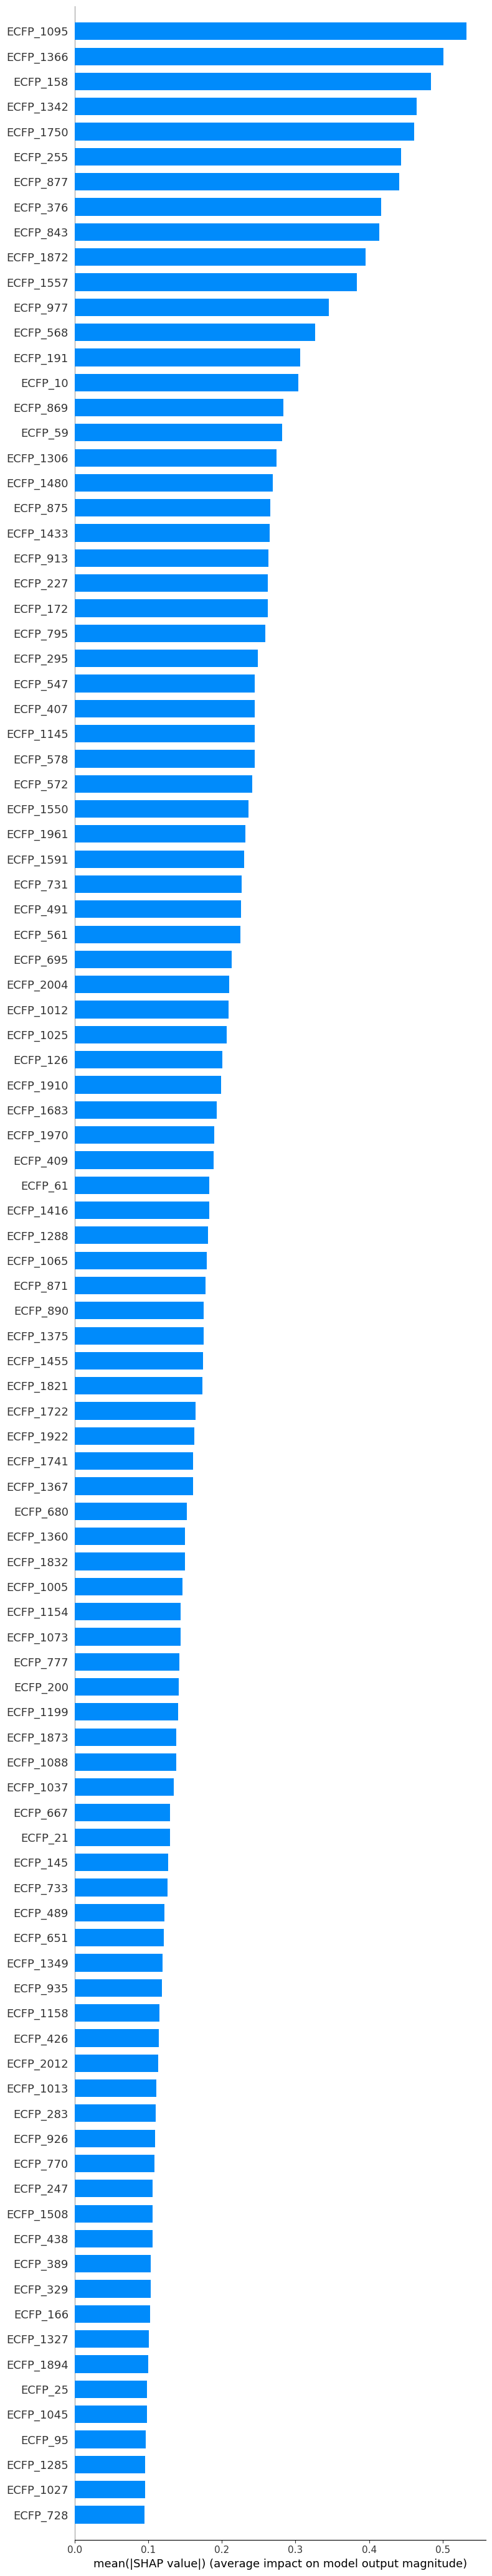

In [72]:
shap.summary_plot(shap_values,
                  test_features[:50],
                  [f'ECFP_{i}' for i in range(2048)],
                  max_display = 100,
                  plot_type='bar',
                  plot_size = 'auto',
                  show_values_in_legend = True)

In [73]:
feat_imp_df = get_feature_importance(shap_values, [f'ECFP_{i}' for i in range(2048)])
print(feat_imp_df['feature_importance'].sum())
print(len(feat_imp_df.query('feature_importance > 0')))
feat_imp_df

31.49306437151737
451


,feature,feature_importance
1095,ECFP_1095,0.531709
1366,ECFP_1366,0.501201
158,ECFP_158,0.483946
1342,ECFP_1342,0.464290
1750,ECFP_1750,0.460968
...,...,...
833,ECFP_833,0.000000
832,ECFP_832,0.000000
847,ECFP_847,0.000000
846,ECFP_846,0.000000


# Permutation

In [58]:
TMP = []
def fp_masker(x, mask):
    print(x.shape, mask.shape, mask.sum())
#     print(np.nonzero(mask)[0])
    TMP.append(mask.sum())
    ret =  np.array([x for _ in range(7)])
    return ret

In [77]:
explainer = shap.PermutationExplainer(partial(mlp_predict, model = model), test_features[:50])
shap_values = explainer.shap_values(test_features[0:10], npermutations=10)

PermutationExplainer explainer: 11it [01:43, 10.39s/it]                        


In [79]:
feat_imp_df = get_feature_importance(shap_values, [f'ECFP_{i}' for i in range(2048)])
print(feat_imp_df['feature_importance'].sum())
print(len(feat_imp_df.query('feature_importance > 0')))
feat_imp_df

30.25388278241591
451


,feature,feature_importance
1366,ECFP_1366,0.590863
843,ECFP_843,0.473900
1095,ECFP_1095,0.463098
158,ECFP_158,0.430822
1342,ECFP_1342,0.396208
...,...,...
326,ECFP_326,0.000000
325,ECFP_325,0.000000
324,ECFP_324,0.000000
323,ECFP_323,0.000000


# Sampling

In [87]:
%%time
explainer = shap.SamplingExplainer(partial(mlp_predict, model = model), test_features[:100])
shap_values = explainer.shap_values(test_features[0:50], nsamples=10)

  0%|          | 0/50 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/shap/explainers/_sampling.py:151: RuntimeWarning: overflow encountered in scalar multiply
  self.X_masked = np.zeros((nsamples_each2.max() * 2, self.data.data.shape[1]))


CPU times: user 3min 34s, sys: 2.04 s, total: 3min 36s
Wall time: 3min 28s


In [89]:
feat_imp_df = get_feature_importance(shap_values, [f'ECFP_{i}' for i in range(2048)])
print(feat_imp_df['feature_importance'].sum())
print(len(feat_imp_df.query('feature_importance > 0')))
feat_imp_df

0.0
0


,feature,feature_importance
0,ECFP_0,NaN
1,ECFP_1,NaN
2,ECFP_2,NaN
3,ECFP_3,NaN
4,ECFP_4,NaN
...,...,...
2043,ECFP_2043,NaN
2044,ECFP_2044,NaN
2045,ECFP_2045,NaN
2046,ECFP_2046,NaN


# Deep

https://github.com/shap/shap/issues/3363

In [141]:
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x, class_idx = None):
        if class_idx is None:
            return self.model(x)
        else:
            return self.model(x)[:, class_idx:class_idx+1]

test_features_tensor = torch.from_numpy(test_features[:1000]).float().to('cuda:2')

In [120]:
ModelWrapper(model).to('cuda:2').eval()(test_features_tensor).shape

torch.Size([1000, 1])

In [128]:
%%time
explainer = shap.DeepExplainer(ModelWrapper(model).to('cuda:2').eval(),
                               test_features_tensor)
shap_values = explainer.shap_values(test_features_tensor, check_additivity=False)
shap_values.shape

/opt/conda/lib/python3.10/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: GELU
  warnings.warn(f'unrecognized nn.Module: {module_type}')


CPU times: user 45.4 s, sys: 220 ms, total: 45.7 s
Wall time: 45.6 s


(1000, 2048, 1)

In [130]:
shap_values = shap_values[..., 0]
feat_imp_df = get_feature_importance(shap_values, [f'ECFP_{i}' for i in range(2048)])
print(feat_imp_df['feature_importance'].sum())
print(len(feat_imp_df.query('feature_importance > 0')))
feat_imp_df

52.37429031492022
675


,feature,feature_importance
1580,ECFP_1580,0.626520
1970,ECFP_1970,0.597177
198,ECFP_198,0.515058
255,ECFP_255,0.513807
392,ECFP_392,0.507726
...,...,...
1021,ECFP_1021,0.000000
1018,ECFP_1018,0.000000
1017,ECFP_1017,0.000000
1016,ECFP_1016,0.000000


# Gradient

In [142]:
%%time
test_features_tensor = torch.from_numpy(test_features[:]).float().to('cuda:2')
explainer = shap.GradientExplainer(ModelWrapper(model).to('cuda:2').eval(),
                                   test_features_tensor,
                                   batch_size=50,
                                   local_smoothing=0)
shap_values = explainer.shap_values(test_features_tensor, nsamples=100)
shap_values.shape

CPU times: user 21min 19s, sys: 10.2 s, total: 21min 30s
Wall time: 21min 30s


(11271, 2048, 3)

In [144]:
shap_values = shap_values[..., 0]
feat_imp_df = get_feature_importance(shap_values, [f'ECFP_{i}' for i in range(2048)])
print(feat_imp_df['feature_importance'].sum())
print(len(feat_imp_df.query('feature_importance > 0')))
feat_imp_df

65.2197870400193
822


,feature,feature_importance
1970,ECFP_1970,0.799470
255,ECFP_255,0.554235
977,ECFP_977,0.461214
352,ECFP_352,0.448122
2004,ECFP_2004,0.424571
...,...,...
317,ECFP_317,0.000000
316,ECFP_316,0.000000
315,ECFP_315,0.000000
312,ECFP_312,0.000000
